In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import itertools as IT
import tslearn
from tslearn.utils import to_time_series_dataset
import TimeSeries_Clustering
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from community import community_louvain
from tqdm import tqdm
import TimeSeries_Clustering
from catboost import CatBoostClassifier
import Evrecsys
import methods

In [2]:
#Import Data
def valid(chunks):
    for chunk in chunks:
        print(chunk.shape)
        mask = chunk['batch'] == 'users_2000'
        if mask.all():
            yield chunk
        else:
            yield chunk.loc[mask]
            #break

chunksize = 10 ** 6
chunks_train = pd.read_csv("1_train.csv", chunksize=chunksize, index_col=0)
train = pd.concat(valid(chunks_train))

chunks_test = pd.read_csv("1_test.csv", chunksize=chunksize, index_col=0)
test = pd.concat(valid(chunks_test))

(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(1000000, 15)
(294701, 15)
(1000000, 14)
(1000000, 14)
(139788, 14)


In [14]:
#orders = pd.read_csv("orders.csv")
#products = pd.read_csv("products.csv")

## Clustering

### Time Series

In [3]:
def cluster_kshape(train, test, return_pred, num_cluster):
    ts=TimeSeries_Clustering.make_timeseries(train)

    formatted_dataset = to_time_series_dataset(ts)
    X_train, sz = TimeSeries_Clustering.normalize_data(formatted_dataset)
    ks, y_pred = TimeSeries_Clustering.k_shape(X_train, n_clusters=num_cluster)
    scores = TimeSeries_Clustering.compute_scores(ks, X_train, y_pred)
    #plt.boxplot(scores)
    silhouette= tslearn.clustering.silhouette_score(X_train, y_pred, metric="euclidean")
    print("For n_clusters =", num_cluster,
            "The average silhouette_score is :", silhouette)
    #TimeSeries_Clustering.plot_data(ks, X_train, y_pred, sz, ks.n_clusters, centroid=True)
    y_pred_df = pd.DataFrame(y_pred)
    userindex = train.user_id.unique()
    userindex = np.sort(userindex)
    y_pred_df['user_id'] = userindex
    y_pred_df= y_pred_df.rename({0: 'cluster'}, axis='columns')
    
    #test = test.merge(y_pred_df, on='user_id').rename({0: 'cluster'}, axis='columns')
    #train = train.merge(y_pred_df, on='user_id').rename({0: 'cluster'}, axis='columns')
    #user_cluster = test.drop_duplicates(subset=['user_id'], keep='first')[['user_id', 'cluster_kshape']]
      #y_pred_df.to_csv('clusters_kshape.csv')
    return y_pred_df

### Features

In [4]:
##CONSTRUCT FEATURES FOR USERS

#Mean, min, max number of products per order
f_products = train.groupby(['user_id'])['total'].agg(['min', 'max', 'mean']).add_prefix('Total').reset_index()
train=train.merge(f_products, on='user_id')

#Number of orders
f_orders = train.groupby(['user_id'])['order_number'].agg(['max']).add_prefix('order_number').reset_index()
train=train.merge(f_orders, on='user_id')

#Mean, min, max days between orders
f_days = train.groupby(['user_id'])['days_since_prior_order'].agg(['min', 'max', 'mean']).add_prefix('days_since_prior_order').reset_index()
train=train.merge(f_days, on='user_id')

#reorder mean, min, max of products per order
total_reorder=train[train['reordered']==1].groupby(['order_id']).size().reset_index(name='total_reorder')
train=train.merge(total_reorder, on='order_id')
f_reorder=train.groupby(['user_id'])['total_reorder'].agg(['min', 'max', 'mean']).add_prefix('reorder').reset_index()
train=train.merge(f_reorder, on='user_id')

#Mean, min, max hours for orders
f_hour = train.groupby(['user_id'])['order_hour_of_day'].agg(['min', 'max', 'mean']).add_prefix('order_hour_of_day').reset_index()
train=train.merge(f_hour, on='user_id')

#average day of week
f_dow = train.groupby(['user_id'])['order_dow'].agg(['mean']).add_prefix('order_dow').reset_index()
train=train.merge(f_dow, on='user_id')

user_features=['user_id','total', 'total_reorder', 'Totalmin', 'Totalmax',
       'Totalmean', 'order_numbermax', 'days_since_prior_ordermin',
       'days_since_prior_ordermax', 'days_since_prior_ordermean',
       'reordermin', 'reordermax', 'reordermean',
       'order_hour_of_daymin', 'order_hour_of_daymax', 'order_hour_of_daymean',
       'days_since_prior_ordermin', 'days_since_prior_ordermax',
       'days_since_prior_ordermean', 'order_dowmean']

In [5]:
train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,...,days_since_prior_ordermax,days_since_prior_ordermean,total_reorder,reordermin,reordermax,reordermean,order_hour_of_daymin,order_hour_of_daymax,order_hour_of_daymean,order_dowmean
0,441,48665,1,1,132697,prior,5,1,13,7.0,...,21.0,13.13125,6,5,15,8.50625,8,21,13.73125,1.3125
1,441,35378,2,0,132697,prior,5,1,13,7.0,...,21.0,13.13125,6,5,15,8.50625,8,21,13.73125,1.3125
2,441,9387,3,1,132697,prior,5,1,13,7.0,...,21.0,13.13125,6,5,15,8.50625,8,21,13.73125,1.3125
3,441,17794,4,0,132697,prior,5,1,13,7.0,...,21.0,13.13125,6,5,15,8.50625,8,21,13.73125,1.3125
4,441,9824,5,0,132697,prior,5,1,13,7.0,...,21.0,13.13125,6,5,15,8.50625,8,21,13.73125,1.3125


In [6]:
def cluster_features(train, test,return_pred, num_cluster):
    random_state=2
    train=train.drop_duplicates(subset='user_id', keep='first')
    train1=train[user_features]
    y_pred_train = KMeans(n_clusters=num_cluster, random_state=random_state).fit_predict(train1)
    y_pred_train_df = pd.DataFrame(y_pred_train)
    y_pred_train_df['user_id'] = train.user_id.values
    y_pred_train_df= y_pred_train_df.rename({0: 'cluster'}, axis='columns')
    #y_pred_test_df.to_csv('clusters_features.csv')
    return y_pred_train_df

### Graph

In [7]:
def cluster_graph(train, test,return_pred, num_cluster):
    FG = nx.from_pandas_edgelist(train, source='user_id', target='product_name', edge_attr=True)
    parts = community_louvain.best_partition(FG)
    y_pred_df = pd.DataFrame.from_dict(parts, orient='index', columns=['cluster']).reset_index()
    y_pred_df=y_pred_df.rename({'index': 'user_id'}, axis='columns')
    #y_pred_df.to_csv('clusters_graph.csv')
    return y_pred_df

### Methods

In [8]:
## Catboost
def catboost(train, test,return_pred, num_cluster): 
    orders_set_test=test.order_id.unique()
    y_train = train['reordered']
    X_train = train.drop(['reordered', 'eval_set', 'batch', 'total','product_name', 'add_to_cart_order'], axis=1)
    X_test = test.drop_duplicates(subset=['order_id', 'user_id'], keep='first')
    X_test=X_test.drop(['product_id','add_to_cart_order', 'reordered', 'eval_set', 'product_name', 'aisle_id', 'department_id', 'batch'], axis=1)
    X_train_sub=train.drop_duplicates(subset=['product_id', 'user_id'], keep='first')
    X_train_sub=X_train_sub[['product_id', 'user_id', 'aisle_id','department_id']]
    X_test=pd.merge(left=X_test, right=X_train_sub, how='right',on=['user_id'])
    X_test = X_test[['order_id', 'product_id', 'user_id', 'order_number', 'order_dow','order_hour_of_day', 'days_since_prior_order', 'aisle_id','department_id']]
    X_train = X_train[['order_id', 'product_id', 'user_id', 'order_number', 'order_dow','order_hour_of_day', 'days_since_prior_order', 'aisle_id','department_id']]
    
    model_cat = CatBoostClassifier(iterations=10, learning_rate=0.02, depth=10, loss_function='Logloss')
    model_cat.fit(X_train, y_train)
    predict_labels= model_cat.predict(X_test)
    
    X_test['pred']=predict_labels
    pred = X_test[X_test['pred'] == 1].groupby('order_id').aggregate({'product_id': lambda x: list(x)})
    true =test[test['reordered'] == 1].groupby('order_id').aggregate({'product_id': lambda x: list(x)})
    sum_recall = 0
    sum_precision = 0
    sum_fscore = 0
    n = len(orders_set_test)
    for i in orders_set_test:
        if i in true.index:
            y = true['product_id'][i]
        else:
            y = 'nan'
        if i in pred.index:
            y_hat = pred['product_id'][i][:10]
        else:
            y_hat = 'nan'

        p, r, f1 = Evrecsys.calculate_prf(y, y_hat)
        sum_precision = sum_precision + p
        sum_recall = sum_recall + r
        sum_fscore = sum_fscore + f1
        
        
    if return_pred==0:
        return sum_recall/n,sum_precision/n ,sum_fscore/n
    else:
        return sum_recall/n,sum_precision/n ,sum_fscore/n, y_pred, y_true

    print('FINISH CATBOOST')
    

## Elbow to find best number of items KMeans

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

cluster_range = np.arange(5,100,10)
cluster_errors = []
train1=train.drop_duplicates(subset='user_id', keep='first')
train_scaled = scaler.fit_transform( train1[user_features])

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit( train_scaled )
    cluster_errors.append( clusters.inertia_ )

/home/grecia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/grecia/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [10]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

Text(0,0.5,'Cluster errors (inertia)')

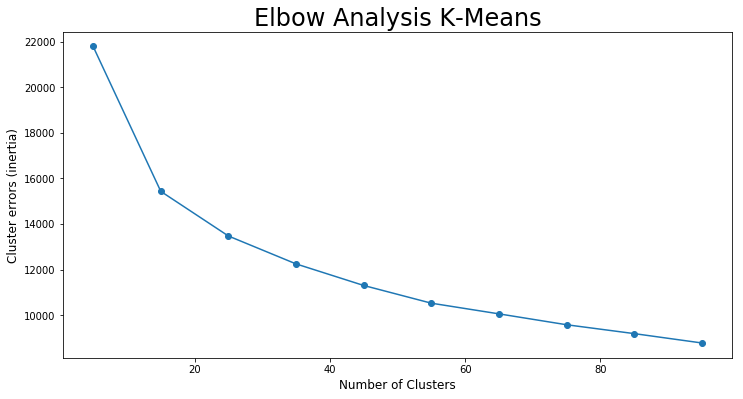

In [11]:
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )
plt.title('Elbow Analysis K-Means',fontsize=24)
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Cluster errors (inertia)", fontsize=12)

## Silhouette Analysis

In [12]:
from sklearn.metrics import silhouette_samples, silhouette_score
print('K-MEANS')
for n_clusters in cluster_range:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict( train_scaled)
    silhouette_avg = silhouette_score(train_scaled, cluster_labels)
    print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(train_scaled, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i


K-MEANS
For n_clusters = 5 The average silhouette_score is : 0.16290367354539362
For n_clusters = 15 The average silhouette_score is : 0.10585340132817009
For n_clusters = 25 The average silhouette_score is : 0.10394455311108038
For n_clusters = 35 The average silhouette_score is : 0.09649758446932868
For n_clusters = 45 The average silhouette_score is : 0.09397272524908507
For n_clusters = 55 The average silhouette_score is : 0.09631960618283622
For n_clusters = 65 The average silhouette_score is : 0.09530540533613986
For n_clusters = 75 The average silhouette_score is : 0.09624914271692663
For n_clusters = 85 The average silhouette_score is : 0.09284893463220344
For n_clusters = 95 The average silhouette_score is : 0.09329657118436421


In [14]:
return_pred=0
print('K-SHAPE')
## Time Series Silhouette and adjusted rand score
for n_clusters in cluster_range:
    pred_df=cluster_kshape(train, test,return_pred, n_clusters)
    #print("For n_clusters =", n_clusters,
       # "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(train_scaled, pred_df.cluster)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

K-SHAPE
0.120 --> 0.111 --> 0.107 --> 0.105 --> 0.104 --> 0.103 --> 0.103 --> 0.102 --> 0.102 --> 0.102 --> 0.101 --> 0.101 --> 0.103 --> 
For n_clusters = 5 The average silhouette_score is : 0.001244226209819691
0.112 --> 0.087 --> 0.085 --> 0.080 --> 0.082 --> 
For n_clusters = 15 The average silhouette_score is : -0.01087049648249752
0.102 --> 0.080 --> 0.074 --> 0.072 --> 0.071 --> 0.071 --> 
For n_clusters = 25 The average silhouette_score is : -0.023838525120113398
0.091 --> 0.074 --> 0.070 --> 0.068 --> 0.066 --> 0.065 --> 0.064 --> 0.064 --> 0.064 --> 
For n_clusters = 35 The average silhouette_score is : -0.03337873841715789
Resumed because of empty cluster
0.093 --> 0.071 --> 0.066 --> 0.064 --> 0.062 --> 0.061 --> 0.061 --> 0.060 --> 0.060 --> 0.060 --> 0.060 --> 
For n_clusters = 45 The average silhouette_score is : -0.04471985218320697
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed because of empty cluster
Resumed

In [23]:
clustering_list=[cluster_kshape, cluster_features, cluster_graph]
clustering_name=['cluster_kshape', 'cluster_features']

methods_list = [methods.top10, methods.last_order, methods.last_reorder, methods.apriori, methods.lightfm, methods.do_xgboost,catboost]
methods_name=['top_10', 'apriori', 'last_order', 'last_reorder', 'lightfm', 'xgboost', 'catboost']


return_pred=0
sum_pred_test=pd.DataFrame()
scores_cluster=pd.DataFrame(columns=['cluster_type', 'cluster_number','method', 'f1', 'total_clusters'])


cluster_range = np.arange(5,65,10)
i=0
for clustering in clustering_list:
    for num_cluster in cluster_range:
        print(clustering_name[i])
        cluster_pred=clustering(train, test, return_pred, num_cluster)
        test_k = test.merge(cluster_pred, on='user_id')
        train_k = train.merge(cluster_pred, on='user_id')
        clusters = train_k['cluster'].unique()
        for cluster in clusters:
            print(cluster)
            train_i = train_k[train_k['cluster'] == cluster]
            test_i = test_k[test_k['cluster'] == cluster]
            sum_rmse=0
            j=0
            for method in methods_list:
                print(methods_name[j])
                print(method)
                print(len(test_i))
                if len(test_i) != 0:
                    r,p,f = method(train_i,test_i, return_pred, num_cluster)
                else:
                     f=np.nan
                 #   y_pred=pd.DataFrame.from_dict({"card_id":[0], 'target':[0]})

                scores_cluster = scores_cluster.append(
                {'cluster_type': clustering_name[i], 'cluster_number': cluster, 'method': methods_name[j], 'f1': f, 'total_clusters':num_cluster},
                ignore_index=True)
                scores_cluster.to_csv('scores_clustering_optimalnumber.csv')
                #sum_pred_test=sum_pred_test.append(y_pred)
                #sum_pred_test.to_csv('scores_clustering.csv')
                j = j + 1
    i=i+1

cluster_kshape
0.120 --> 0.111 --> 0.107 --> 0.105 --> 0.104 --> 0.103 --> 0.103 --> 0.102 --> 0.102 --> 0.102 --> 0.101 --> 0.101 --> 0.103 --> 
For n_clusters = 5 The average silhouette_score is : 0.001244226209819691
4
top_10
<function top10 at 0x7fb73282ec80>
3552
317
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
3552


/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/methods.py:30: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  top_reorder_train=train.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'sum'})['Total_reorders'].sort_values(ascending=False).head(10)


317
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
3552
317
FINISH LAST REORDER
last_reorder
<function apriori at 0x7fb729e7bbf8>
3552
Starting order_item:                  78062
Items with support >= 0.01:            9782
Remaining order_item:                 78062
Remaining orders with 2+ items:        7048
Remaining order_item:                 77870


/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/Apriori.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  order_item = order_item.reset_index().as_matrix()


Item pairs:                          367810
Item pairs with support >= 0.01:     367810

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
3552
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
3552
[15:23:51] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
3552
0:	learn: 0.6875542	total: 53.7ms	remaining: 483ms
1:	learn: 0.6821996	total: 99.2ms	remaining: 397ms
2:	learn: 0.6770487	total: 148ms	remaining: 345ms
3:	learn: 0.6722069	total: 194ms	remaining: 291ms
4:	learn: 0.6674397	total: 240ms	remaining: 240ms
5:	learn: 0.6632590	total: 284ms	remaining: 190ms
6:	learn: 0.6590780	total: 328ms	remaining: 141ms
7:	learn: 0.6549341	total: 374ms	remaining: 93.4ms
8:	learn: 0.6509893	total: 419ms	remaining: 46.6ms
9:	learn: 0.6470427	total: 467ms	remaining: 0us
1
top_10
<function top10 at 0x7fb73282ec80>
3966
389
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
396

/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/methods.py:30: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  top_reorder_train=train.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'sum'})['Total_reorders'].sort_values(ascending=False).head(10)


194
FINISH LAST REORDER
last_reorder
<function apriori at 0x7fb729e7bbf8>
2179
Starting order_item:                  30082
Items with support >= 0.01:            5324
Remaining order_item:                 30082
Remaining orders with 2+ items:        2479
Remaining order_item:                 30009


/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/Apriori.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  order_item = order_item.reset_index().as_matrix()


Item pairs:                          169530
Item pairs with support >= 0.01:     169530

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
2179
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
2179
[15:29:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
2179
0:	learn: 0.6882712	total: 299ms	remaining: 2.69s
1:	learn: 0.6838702	total: 591ms	remaining: 2.36s
2:	learn: 0.6794458	total: 890ms	remaining: 2.08s
3:	learn: 0.6752315	total: 1.18s	remaining: 1.77s
4:	learn: 0.6707237	total: 1.49s	remaining: 1.49s
5:	learn: 0.6665201	total: 1.8s	remaining: 1.2s
6:	learn: 0.6629917	total: 2.09s	remaining: 897ms
7:	learn: 0.6596796	total: 2.37s	remaining: 593ms
8:	learn: 0.6562242	total: 2.66s	remaining: 295ms
9:	learn: 0.6533261	total: 2.95s	remaining: 0us
11
top_10
<function top10 at 0x7fb73282ec80>
1953
177
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
1953
177

Item pairs:                           92371
Item pairs with support >= 0.01:      92371

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
1533
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
1533
[15:32:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
1533
0:	learn: 0.6901025	total: 288ms	remaining: 2.59s
1:	learn: 0.6869617	total: 599ms	remaining: 2.39s
2:	learn: 0.6841954	total: 850ms	remaining: 1.98s
3:	learn: 0.6818758	total: 953ms	remaining: 1.43s
4:	learn: 0.6793966	total: 1.19s	remaining: 1.19s
5:	learn: 0.6770108	total: 1.26s	remaining: 840ms
6:	learn: 0.6743117	total: 1.5s	remaining: 641ms
7:	learn: 0.6717895	total: 1.73s	remaining: 434ms
8:	learn: 0.6693290	total: 1.97s	remaining: 219ms
9:	learn: 0.6673687	total: 2.21s	remaining: 0us
8
top_10
<function top10 at 0x7fb73282ec80>
815
62
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
815
62
FIN

/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


Item pairs:                           41380
Item pairs with support >= 0.01:      41380

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
208
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
208
[15:34:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
208
0:	learn: 0.6867293	total: 370ms	remaining: 3.33s
1:	learn: 0.6809049	total: 652ms	remaining: 2.61s
2:	learn: 0.6757161	total: 927ms	remaining: 2.16s
3:	learn: 0.6710533	total: 1.15s	remaining: 1.73s
4:	learn: 0.6661134	total: 1.4s	remaining: 1.4s
5:	learn: 0.6617274	total: 1.45s	remaining: 969ms
6:	learn: 0.6570212	total: 1.68s	remaining: 722ms
7:	learn: 0.6530598	total: 1.92s	remaining: 480ms
8:	learn: 0.6484364	total: 2.15s	remaining: 239ms
9:	learn: 0.6429803	total: 2.4s	remaining: 0us
3
top_10
<function top10 at 0x7fb73282ec80>
1509
142
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
1509
142
FINI

/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/methods.py:30: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  top_reorder_train=train.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'sum'})['Total_reorders'].sort_values(ascending=False).head(10)


76
FINISH LAST REORDER
last_reorder
<function apriori at 0x7fb729e7bbf8>
781
Starting order_item:                  11471
Items with support >= 0.01:            3123
Remaining order_item:                 11471
Remaining orders with 2+ items:        1008
Remaining order_item:                 11439


/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/Apriori.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  order_item = order_item.reset_index().as_matrix()


Item pairs:                           70532
Item pairs with support >= 0.01:      70532

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
781
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
781
[15:37:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
781
0:	learn: 0.6891357	total: 223ms	remaining: 2s
1:	learn: 0.6861638	total: 438ms	remaining: 1.75s
2:	learn: 0.6830865	total: 487ms	remaining: 1.14s
3:	learn: 0.6799147	total: 619ms	remaining: 928ms
4:	learn: 0.6774479	total: 673ms	remaining: 673ms
5:	learn: 0.6751122	total: 882ms	remaining: 588ms
6:	learn: 0.6717947	total: 1.13s	remaining: 486ms
7:	learn: 0.6686486	total: 1.35s	remaining: 337ms
8:	learn: 0.6655118	total: 1.55s	remaining: 173ms
9:	learn: 0.6631688	total: 1.76s	remaining: 0us
5
top_10
<function top10 at 0x7fb73282ec80>
1079
92
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
1079


/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


92
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
1079
92
FINISH LAST REORDER
last_reorder
<function apriori at 0x7fb729e7bbf8>
1079
Starting order_item:                  16884
Items with support >= 0.01:            3805
Remaining order_item:                 16884
Remaining orders with 2+ items:        1556
Remaining order_item:                 16843
Item pairs:                           86821
Item pairs with support >= 0.01:      86821

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
1079
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
1079
[15:38:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
1079
0:	learn: 0.6890548	total: 244ms	remaining: 2.2s
1:	learn: 0.6853128	total: 490ms	remaining: 1.96s
2:	learn: 0.6814091	total: 749ms	remaining: 1.75s
3:	learn: 0.6775174	total: 1s	remaining: 1.5s
4:	learn: 0.6748353	total: 1.06s	remaining: 1.06

Item pairs:                           40833
Item pairs with support >= 0.01:      40833

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
599
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
599
[15:40:26] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
599
0:	learn: 0.6857180	total: 229ms	remaining: 2.06s
1:	learn: 0.6792247	total: 446ms	remaining: 1.78s
2:	learn: 0.6711756	total: 646ms	remaining: 1.51s
3:	learn: 0.6645674	total: 893ms	remaining: 1.34s
4:	learn: 0.6572429	total: 1.18s	remaining: 1.18s
5:	learn: 0.6516930	total: 1.39s	remaining: 928ms
6:	learn: 0.6460613	total: 1.58s	remaining: 679ms
7:	learn: 0.6415999	total: 1.64s	remaining: 410ms
8:	learn: 0.6352168	total: 1.88s	remaining: 209ms
9:	learn: 0.6306908	total: 2.16s	remaining: 0us
4
top_10
<function top10 at 0x7fb73282ec80>
328
35
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
328
35
FINIS

Item pairs:                           61616
Item pairs with support >= 0.01:      61616

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
618
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
618
[15:43:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
618
0:	learn: 0.6891577	total: 321ms	remaining: 2.89s
1:	learn: 0.6853976	total: 482ms	remaining: 1.93s
2:	learn: 0.6816138	total: 705ms	remaining: 1.65s
3:	learn: 0.6778817	total: 919ms	remaining: 1.38s
4:	learn: 0.6741700	total: 1.17s	remaining: 1.17s
5:	learn: 0.6705091	total: 1.38s	remaining: 918ms
6:	learn: 0.6670286	total: 1.58s	remaining: 677ms
7:	learn: 0.6637684	total: 1.82s	remaining: 454ms
8:	learn: 0.6607832	total: 2.05s	remaining: 228ms
9:	learn: 0.6577351	total: 2.27s	remaining: 0us
3
top_10
<function top10 at 0x7fb73282ec80>
107
11
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
107
11
FINIS

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
74
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
74
[15:45:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
74
0:	learn: 0.6860421	total: 203ms	remaining: 1.83s
1:	learn: 0.6796983	total: 419ms	remaining: 1.68s
2:	learn: 0.6735463	total: 592ms	remaining: 1.38s
3:	learn: 0.6678496	total: 769ms	remaining: 1.15s
4:	learn: 0.6615402	total: 969ms	remaining: 969ms
5:	learn: 0.6553024	total: 1.17s	remaining: 778ms
6:	learn: 0.6494853	total: 1.35s	remaining: 578ms
7:	learn: 0.6456957	total: 1.37s	remaining: 342ms
8:	learn: 0.6408639	total: 1.49s	remaining: 166ms
9:	learn: 0.6372153	total: 1.52s	remaining: 0us
0
top_10
<function top10 at 0x7fb73282ec80>
577
62
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
577
62
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
577
62
FINISH LAST REORDER

/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/methods.py:30: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  top_reorder_train=train.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'sum'})['Total_reorders'].sort_values(ascending=False).head(10)


34
FINISH LAST REORDER
last_reorder
<function apriori at 0x7fb729e7bbf8>
331
Starting order_item:                   4845
Items with support >= 0.01:            1595
Remaining order_item:                  4845
Remaining orders with 2+ items:         468
Remaining order_item:                  4829


/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/Apriori.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  order_item = order_item.reset_index().as_matrix()


Item pairs:                           25115
Item pairs with support >= 0.01:      25115

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
331
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
331
[15:48:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
331
0:	learn: 0.6893192	total: 196ms	remaining: 1.76s
1:	learn: 0.6853042	total: 382ms	remaining: 1.53s
2:	learn: 0.6816033	total: 562ms	remaining: 1.31s
3:	learn: 0.6787013	total: 696ms	remaining: 1.04s
4:	learn: 0.6741709	total: 884ms	remaining: 884ms
5:	learn: 0.6708006	total: 1.01s	remaining: 676ms
6:	learn: 0.6672999	total: 1.2s	remaining: 516ms
7:	learn: 0.6640794	total: 1.39s	remaining: 346ms
8:	learn: 0.6621887	total: 1.41s	remaining: 157ms
9:	learn: 0.6599157	total: 1.46s	remaining: 0us
21
top_10
<function top10 at 0x7fb73282ec80>
513
40
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
513
40
FINIS

/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


9
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
151
9
FINISH LAST REORDER
last_reorder
<function apriori at 0x7fb729e7bbf8>
151
Starting order_item:                   6271
Items with support >= 0.01:            1075
Remaining order_item:                  6271
Remaining orders with 2+ items:         327
Remaining order_item:                  6267
Item pairs:                           44638
Item pairs with support >= 0.01:      44638

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
151
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
151
[15:50:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
151
0:	learn: 0.6829655	total: 61ms	remaining: 549ms
1:	learn: 0.6721756	total: 245ms	remaining: 980ms
2:	learn: 0.6627117	total: 437ms	remaining: 1.02s
3:	learn: 0.6529562	total: 627ms	remaining: 941ms
4:	learn: 0.6437284	total: 806ms	remaining: 806ms
5

41
FINISH LAST REORDER
last_reorder
<function apriori at 0x7fb729e7bbf8>
476
Starting order_item:                  14764
Items with support >= 0.01:            2934
Remaining order_item:                 14764
Remaining orders with 2+ items:        1352
Remaining order_item:                 14731
Item pairs:                           65725
Item pairs with support >= 0.01:      65725

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
476
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
476
[15:52:22] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
476
0:	learn: 0.6860331	total: 272ms	remaining: 2.44s
1:	learn: 0.6798970	total: 494ms	remaining: 1.98s
2:	learn: 0.6737496	total: 738ms	remaining: 1.72s
3:	learn: 0.6674219	total: 969ms	remaining: 1.45s
4:	learn: 0.6615634	total: 1.2s	remaining: 1.2s
5:	learn: 0.6564695	total: 1.42s	remaining: 948ms
6:	learn: 0.6510242	total: 1

last_reorder
<function apriori at 0x7fb729e7bbf8>
743
Starting order_item:                   9121
Items with support >= 0.01:            2901
Remaining order_item:                  9121
Remaining orders with 2+ items:         896
Remaining order_item:                  9096
Item pairs:                           53308
Item pairs with support >= 0.01:      53308

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
743
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
743
[15:54:39] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
743
0:	learn: 0.6895843	total: 230ms	remaining: 2.07s
1:	learn: 0.6869107	total: 457ms	remaining: 1.83s
2:	learn: 0.6842962	total: 677ms	remaining: 1.58s
3:	learn: 0.6818533	total: 893ms	remaining: 1.34s
4:	learn: 0.6789509	total: 1.1s	remaining: 1.1s
5:	learn: 0.6763871	total: 1.33s	remaining: 885ms
6:	learn: 0.6744343	total: 1.4s	remaining: 600ms
7:

Item pairs:                           52864
Item pairs with support >= 0.01:      52864

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
397
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
397
[15:56:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
397
0:	learn: 0.6877949	total: 221ms	remaining: 1.99s
1:	learn: 0.6829919	total: 427ms	remaining: 1.71s
2:	learn: 0.6782368	total: 639ms	remaining: 1.49s
3:	learn: 0.6741032	total: 849ms	remaining: 1.27s
4:	learn: 0.6709216	total: 897ms	remaining: 897ms
5:	learn: 0.6669795	total: 1.11s	remaining: 740ms
6:	learn: 0.6628422	total: 1.32s	remaining: 564ms
7:	learn: 0.6585006	total: 1.55s	remaining: 387ms
8:	learn: 0.6542178	total: 1.76s	remaining: 196ms
9:	learn: 0.6509248	total: 1.98s	remaining: 0us
27
top_10
<function top10 at 0x7fb73282ec80>
534
57
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
534
57
FINI

Item pairs:                           28577
Item pairs with support >= 0.01:      28577

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
545
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
545
[15:58:08] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
545
0:	learn: 0.6888322	total: 71.5ms	remaining: 644ms
1:	learn: 0.6847255	total: 272ms	remaining: 1.09s
2:	learn: 0.6808158	total: 453ms	remaining: 1.06s
3:	learn: 0.6770381	total: 619ms	remaining: 928ms
4:	learn: 0.6728822	total: 802ms	remaining: 802ms
5:	learn: 0.6700114	total: 870ms	remaining: 580ms
6:	learn: 0.6669433	total: 1.05s	remaining: 451ms
7:	learn: 0.6638225	total: 1.23s	remaining: 307ms
8:	learn: 0.6606732	total: 1.4s	remaining: 156ms
9:	learn: 0.6581847	total: 1.47s	remaining: 0us
10
top_10
<function top10 at 0x7fb73282ec80>
592
53
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
592
53
FINI

/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/methods.py:30: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  top_reorder_train=train.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'sum'})['Total_reorders'].sort_values(ascending=False).head(10)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


43
FINISH LAST REORDER
last_reorder
<function apriori at 0x7fb729e7bbf8>
453
Starting order_item:                   8533
Items with support >= 0.01:            2063
Remaining order_item:                  8533
Remaining orders with 2+ items:         698
Remaining order_item:                  8516


/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/Apriori.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  order_item = order_item.reset_index().as_matrix()


Item pairs:                           48794
Item pairs with support >= 0.01:      48794

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
453
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
453
[16:02:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
453
0:	learn: 0.6857938	total: 210ms	remaining: 1.89s
1:	learn: 0.6790264	total: 416ms	remaining: 1.66s
2:	learn: 0.6724795	total: 627ms	remaining: 1.46s
3:	learn: 0.6670120	total: 846ms	remaining: 1.27s
4:	learn: 0.6606601	total: 1.05s	remaining: 1.05s
5:	learn: 0.6549443	total: 1.25s	remaining: 833ms
6:	learn: 0.6498611	total: 1.33s	remaining: 569ms
7:	learn: 0.6444339	total: 1.51s	remaining: 378ms
8:	learn: 0.6397286	total: 1.73s	remaining: 192ms
9:	learn: 0.6346115	total: 1.93s	remaining: 0us
32
top_10
<function top10 at 0x7fb73282ec80>
596
56
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
596
56
FINI

Item pairs with support >= 0.01:      12276

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
102
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
102
[16:03:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
102
0:	learn: 0.6876156	total: 166ms	remaining: 1.49s
1:	learn: 0.6831786	total: 225ms	remaining: 899ms
2:	learn: 0.6792227	total: 383ms	remaining: 893ms
3:	learn: 0.6747657	total: 535ms	remaining: 803ms
4:	learn: 0.6727314	total: 552ms	remaining: 552ms
5:	learn: 0.6680146	total: 731ms	remaining: 488ms
6:	learn: 0.6645038	total: 796ms	remaining: 341ms
7:	learn: 0.6621902	total: 835ms	remaining: 209ms
8:	learn: 0.6576377	total: 1.03s	remaining: 115ms
9:	learn: 0.6546551	total: 1.19s	remaining: 0us
6
top_10
<function top10 at 0x7fb73282ec80>
720
67
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
720
67
FINISH LAST ORDER
last_order
<function last_reord

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
357
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
357
[16:05:06] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
357
0:	learn: 0.6856143	total: 309ms	remaining: 2.78s
1:	learn: 0.6786865	total: 642ms	remaining: 2.57s
2:	learn: 0.6733144	total: 702ms	remaining: 1.64s
3:	learn: 0.6668270	total: 1.02s	remaining: 1.53s
4:	learn: 0.6607491	total: 1.17s	remaining: 1.17s
5:	learn: 0.6549870	total: 1.5s	remaining: 1s
6:	learn: 0.6489995	total: 1.83s	remaining: 784ms
7:	learn: 0.6436573	total: 2.15s	remaining: 537ms
8:	learn: 0.6379945	total: 2.42s	remaining: 269ms
9:	learn: 0.6328794	total: 2.67s	remaining: 0us
27
top_10
<function top10 at 0x7fb73282ec80>
223
17
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
223
17
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
223
17
FINISH LAST REORDER

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
586
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
586
[16:06:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
586
0:	learn: 0.6915960	total: 42.4ms	remaining: 381ms
1:	learn: 0.6899161	total: 86.4ms	remaining: 346ms
2:	learn: 0.6876841	total: 270ms	remaining: 631ms
3:	learn: 0.6853107	total: 311ms	remaining: 466ms
4:	learn: 0.6833422	total: 477ms	remaining: 477ms
5:	learn: 0.6817951	total: 514ms	remaining: 343ms
6:	learn: 0.6791324	total: 825ms	remaining: 353ms
7:	learn: 0.6770317	total: 1.04s	remaining: 261ms
8:	learn: 0.6749639	total: 1.24s	remaining: 137ms
9:	learn: 0.6729662	total: 1.42s	remaining: 0us
30
top_10
<function top10 at 0x7fb73282ec80>
305
30
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
305
30
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
305
30
FINISH LAST R

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
241
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
241
[16:08:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
241
0:	learn: 0.6881003	total: 29.8ms	remaining: 269ms
1:	learn: 0.6836466	total: 214ms	remaining: 858ms
2:	learn: 0.6782675	total: 382ms	remaining: 892ms
3:	learn: 0.6738347	total: 444ms	remaining: 666ms
4:	learn: 0.6684064	total: 614ms	remaining: 614ms
5:	learn: 0.6641073	total: 654ms	remaining: 436ms
6:	learn: 0.6592788	total: 825ms	remaining: 353ms
7:	learn: 0.6545174	total: 1.01s	remaining: 252ms
8:	learn: 0.6505992	total: 1.18s	remaining: 131ms
9:	learn: 0.6453998	total: 1.37s	remaining: 0us
35
top_10
<function top10 at 0x7fb73282ec80>
359
34
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
359
34
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
359
34
FINISH LAST RE

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
752
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
752
[16:09:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
752
0:	learn: 0.6905793	total: 173ms	remaining: 1.55s
1:	learn: 0.6877761	total: 346ms	remaining: 1.38s
2:	learn: 0.6852751	total: 518ms	remaining: 1.21s
3:	learn: 0.6822425	total: 766ms	remaining: 1.15s
4:	learn: 0.6805418	total: 811ms	remaining: 811ms
5:	learn: 0.6778488	total: 1.01s	remaining: 672ms
6:	learn: 0.6754079	total: 1.18s	remaining: 505ms
7:	learn: 0.6730444	total: 1.35s	remaining: 339ms
8:	learn: 0.6701589	total: 1.57s	remaining: 175ms
9:	learn: 0.6687229	total: 1.62s	remaining: 0us
1
top_10
<function top10 at 0x7fb73282ec80>
442
44
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
442
44
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
442
44
FINISH LAST REOR

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
820
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
820
[16:11:11] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
820
0:	learn: 0.6914260	total: 32.6ms	remaining: 294ms
1:	learn: 0.6883093	total: 245ms	remaining: 982ms
2:	learn: 0.6867324	total: 273ms	remaining: 638ms
3:	learn: 0.6846587	total: 419ms	remaining: 628ms
4:	learn: 0.6821951	total: 629ms	remaining: 629ms
5:	learn: 0.6800322	total: 834ms	remaining: 556ms
6:	learn: 0.6774983	total: 1.04s	remaining: 445ms
7:	learn: 0.6752293	total: 1.24s	remaining: 309ms
8:	learn: 0.6731827	total: 1.47s	remaining: 164ms
9:	learn: 0.6713648	total: 1.61s	remaining: 0us
43
top_10
<function top10 at 0x7fb73282ec80>
412
47
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
412
47
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
412
47
FINISH LAST RE

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
235
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
235
[16:12:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
235
0:	learn: 0.6852434	total: 195ms	remaining: 1.75s
1:	learn: 0.6780459	total: 409ms	remaining: 1.63s
2:	learn: 0.6710294	total: 614ms	remaining: 1.43s
3:	learn: 0.6645812	total: 809ms	remaining: 1.21s
4:	learn: 0.6579816	total: 1s	remaining: 1s
5:	learn: 0.6518897	total: 1.22s	remaining: 815ms
6:	learn: 0.6463785	total: 1.3s	remaining: 560ms
7:	learn: 0.6410041	total: 1.5s	remaining: 374ms
8:	learn: 0.6358572	total: 1.69s	remaining: 187ms
9:	learn: 0.6309631	total: 1.88s	remaining: 0us
10
top_10
<function top10 at 0x7fb73282ec80>
277
21
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
277
21
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
277
21
FINISH LAST REORDER
las

/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/methods.py:30: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  top_reorder_train=train.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'sum'})['Total_reorders'].sort_values(ascending=False).head(10)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/Apriori.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  order_item = order_item.reset_index().as_matrix()


Item pairs:                           29343
Item pairs with support >= 0.01:      29343

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
284
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
284
[16:17:27] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
284
0:	learn: 0.6878733	total: 166ms	remaining: 1.5s
1:	learn: 0.6827994	total: 329ms	remaining: 1.32s
2:	learn: 0.6766855	total: 494ms	remaining: 1.15s
3:	learn: 0.6714504	total: 662ms	remaining: 993ms
4:	learn: 0.6665197	total: 831ms	remaining: 831ms
5:	learn: 0.6626220	total: 990ms	remaining: 660ms
6:	learn: 0.6580022	total: 1.15s	remaining: 493ms
7:	learn: 0.6536565	total: 1.34s	remaining: 336ms
8:	learn: 0.6500426	total: 1.41s	remaining: 157ms
9:	learn: 0.6463727	total: 1.45s	remaining: 0us
21
top_10
<function top10 at 0x7fb73282ec80>
515
50
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
515
50
FINIS

Item pairs:                           18902
Item pairs with support >= 0.01:      18902

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
165
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
165
[16:18:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
165
0:	learn: 0.6807159	total: 177ms	remaining: 1.59s
1:	learn: 0.6685253	total: 353ms	remaining: 1.41s
2:	learn: 0.6593181	total: 374ms	remaining: 872ms
3:	learn: 0.6496690	total: 549ms	remaining: 824ms
4:	learn: 0.6394064	total: 722ms	remaining: 722ms
5:	learn: 0.6300975	total: 901ms	remaining: 600ms
6:	learn: 0.6201638	total: 1.07s	remaining: 457ms
7:	learn: 0.6116730	total: 1.11s	remaining: 278ms
8:	learn: 0.6035113	total: 1.26s	remaining: 140ms
9:	learn: 0.5959213	total: 1.44s	remaining: 0us
12
top_10
<function top10 at 0x7fb73282ec80>
722
71
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
722
71
FINI

Item pairs:                           76456
Item pairs with support >= 0.01:      76456

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
368
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
368
[16:20:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
368
0:	learn: 0.6853673	total: 293ms	remaining: 2.63s
1:	learn: 0.6776218	total: 578ms	remaining: 2.31s
2:	learn: 0.6704498	total: 829ms	remaining: 1.94s
3:	learn: 0.6635373	total: 1.08s	remaining: 1.62s
4:	learn: 0.6561549	total: 1.33s	remaining: 1.33s
5:	learn: 0.6499675	total: 1.59s	remaining: 1.06s
6:	learn: 0.6432308	total: 1.82s	remaining: 779ms
7:	learn: 0.6371933	total: 2.06s	remaining: 516ms
8:	learn: 0.6320529	total: 2.31s	remaining: 257ms
9:	learn: 0.6263697	total: 2.56s	remaining: 0us
34
top_10
<function top10 at 0x7fb73282ec80>
349
32
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
349
32
FINI

Item pairs:                           14963
Item pairs with support >= 0.01:      14963

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
530
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
530
[16:21:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
530
0:	learn: 0.6907575	total: 174ms	remaining: 1.56s
1:	learn: 0.6879925	total: 347ms	remaining: 1.39s
2:	learn: 0.6849693	total: 532ms	remaining: 1.24s
3:	learn: 0.6843661	total: 551ms	remaining: 826ms
4:	learn: 0.6812665	total: 707ms	remaining: 707ms
5:	learn: 0.6793953	total: 882ms	remaining: 588ms
6:	learn: 0.6757450	total: 997ms	remaining: 427ms
7:	learn: 0.6727642	total: 1.17s	remaining: 293ms
8:	learn: 0.6704088	total: 1.33s	remaining: 148ms
9:	learn: 0.6684010	total: 1.5s	remaining: 0us
2
top_10
<function top10 at 0x7fb73282ec80>
500
40
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
500
40
FINISH

Item pairs:                           12919
Item pairs with support >= 0.01:      12919

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
218
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
218
[16:23:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
218
0:	learn: 0.6864437	total: 164ms	remaining: 1.48s
1:	learn: 0.6791280	total: 343ms	remaining: 1.37s
2:	learn: 0.6739637	total: 368ms	remaining: 858ms
3:	learn: 0.6670132	total: 547ms	remaining: 821ms
4:	learn: 0.6607773	total: 725ms	remaining: 725ms
5:	learn: 0.6551980	total: 887ms	remaining: 591ms
6:	learn: 0.6504086	total: 962ms	remaining: 412ms
7:	learn: 0.6455136	total: 1.03s	remaining: 258ms
8:	learn: 0.6396934	total: 1.2s	remaining: 133ms
9:	learn: 0.6355191	total: 1.32s	remaining: 0us
4
top_10
<function top10 at 0x7fb73282ec80>
205
19
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
205
19
FINISH

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
986
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
986
[16:24:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
986
0:	learn: 0.6903038	total: 174ms	remaining: 1.56s
1:	learn: 0.6876290	total: 335ms	remaining: 1.34s
2:	learn: 0.6853791	total: 399ms	remaining: 932ms
3:	learn: 0.6828872	total: 563ms	remaining: 844ms
4:	learn: 0.6807763	total: 726ms	remaining: 726ms
5:	learn: 0.6787643	total: 884ms	remaining: 589ms
6:	learn: 0.6765399	total: 1.06s	remaining: 455ms
7:	learn: 0.6747355	total: 1.17s	remaining: 293ms
8:	learn: 0.6725831	total: 1.34s	remaining: 149ms
9:	learn: 0.6701601	total: 1.51s	remaining: 0us
53
top_10
<function top10 at 0x7fb73282ec80>
373
41
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
373
41
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
373
41
FINISH LAST REO

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
213
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
213
[16:26:05] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
213
0:	learn: 0.6890358	total: 26.9ms	remaining: 242ms
1:	learn: 0.6830942	total: 217ms	remaining: 866ms
2:	learn: 0.6789188	total: 386ms	remaining: 900ms
3:	learn: 0.6745616	total: 558ms	remaining: 838ms
4:	learn: 0.6704684	total: 598ms	remaining: 598ms
5:	learn: 0.6653132	total: 769ms	remaining: 513ms
6:	learn: 0.6605246	total: 950ms	remaining: 407ms
7:	learn: 0.6557209	total: 1.12s	remaining: 281ms
8:	learn: 0.6507126	total: 1.29s	remaining: 144ms
9:	learn: 0.6461316	total: 1.47s	remaining: 0us
54
top_10
<function top10 at 0x7fb73282ec80>
471
46
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
471
46
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
471
46
FINISH LAST RE

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
382
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
382
[16:27:13] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
382
0:	learn: 0.6897918	total: 176ms	remaining: 1.58s
1:	learn: 0.6870814	total: 345ms	remaining: 1.38s
2:	learn: 0.6841903	total: 563ms	remaining: 1.31s
3:	learn: 0.6818624	total: 617ms	remaining: 926ms
4:	learn: 0.6787945	total: 835ms	remaining: 835ms
5:	learn: 0.6763733	total: 1.01s	remaining: 672ms
6:	learn: 0.6734097	total: 1.18s	remaining: 506ms
7:	learn: 0.6703683	total: 1.38s	remaining: 344ms
8:	learn: 0.6676642	total: 1.54s	remaining: 171ms
9:	learn: 0.6653331	total: 1.7s	remaining: 0us
7
top_10
<function top10 at 0x7fb73282ec80>
117
13
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
117
13
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
117
13
FINISH LAST REORD

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
207
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
207
[16:28:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
207
0:	learn: 0.6801188	total: 156ms	remaining: 1.4s
1:	learn: 0.6686034	total: 224ms	remaining: 895ms
2:	learn: 0.6608677	total: 242ms	remaining: 566ms
3:	learn: 0.6487656	total: 403ms	remaining: 605ms
4:	learn: 0.6403991	total: 454ms	remaining: 454ms
5:	learn: 0.6321479	total: 475ms	remaining: 316ms
6:	learn: 0.6225316	total: 631ms	remaining: 271ms
7:	learn: 0.6136002	total: 782ms	remaining: 195ms
8:	learn: 0.6044502	total: 951ms	remaining: 106ms
9:	learn: 0.5963108	total: 1.11s	remaining: 0us
45
top_10
<function top10 at 0x7fb73282ec80>
246
24
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
246
24
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
246
24
FINISH LAST REOR

FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
75
[16:28:59] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
75
0:	learn: 0.6860119	total: 67.3ms	remaining: 606ms
1:	learn: 0.6797693	total: 109ms	remaining: 438ms
2:	learn: 0.6736192	total: 125ms	remaining: 292ms
3:	learn: 0.6669978	total: 249ms	remaining: 373ms
4:	learn: 0.6606670	total: 323ms	remaining: 323ms
5:	learn: 0.6540425	total: 440ms	remaining: 293ms
6:	learn: 0.6470491	total: 515ms	remaining: 221ms
7:	learn: 0.6402599	total: 601ms	remaining: 150ms
8:	learn: 0.6354452	total: 723ms	remaining: 80.3ms
9:	learn: 0.6282156	total: 848ms	remaining: 0us
cluster_features
0
top_10
<function top10 at 0x7fb73282ec80>
4101
383
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
4101


/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/methods.py:30: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  top_reorder_train=train.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'sum'})['Total_reorders'].sort_values(ascending=False).head(10)


383
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
4101
383
FINISH LAST REORDER
last_reorder
<function apriori at 0x7fb729e7bbf8>
4101
Starting order_item:                  47029
Items with support >= 0.01:            7735
Remaining order_item:                 47029
Remaining orders with 2+ items:        4269
Remaining order_item:                 46886


/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/Apriori.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  order_item = order_item.reset_index().as_matrix()


Item pairs:                          236369
Item pairs with support >= 0.01:     236369

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
4101
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
4101
[16:29:53] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
4101
0:	learn: 0.6892187	total: 339ms	remaining: 3.05s
1:	learn: 0.6853591	total: 659ms	remaining: 2.63s
2:	learn: 0.6816723	total: 954ms	remaining: 2.23s
3:	learn: 0.6785504	total: 1.01s	remaining: 1.51s
4:	learn: 0.6750142	total: 1.3s	remaining: 1.3s
5:	learn: 0.6719517	total: 1.59s	remaining: 1.06s
6:	learn: 0.6685940	total: 1.88s	remaining: 804ms
7:	learn: 0.6658865	total: 2.17s	remaining: 542ms
8:	learn: 0.6629335	total: 2.46s	remaining: 274ms
9:	learn: 0.6599542	total: 2.76s	remaining: 0us
4
top_10
<function top10 at 0x7fb73282ec80>
3475
342
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
3475
342


/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/methods.py:30: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  top_reorder_train=train.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'sum'})['Total_reorders'].sort_values(ascending=False).head(10)


109
FINISH LAST REORDER
last_reorder
<function apriori at 0x7fb729e7bbf8>
1234
Starting order_item:                  14029
Items with support >= 0.01:            3406
Remaining order_item:                 14029
Remaining orders with 2+ items:        1277
Remaining order_item:                 13977


/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/Apriori.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  order_item = order_item.reset_index().as_matrix()


Item pairs:                           71028
Item pairs with support >= 0.01:      71028

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
1234
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
1234
[16:34:30] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
1234
0:	learn: 0.6876689	total: 258ms	remaining: 2.32s
1:	learn: 0.6822828	total: 502ms	remaining: 2.01s
2:	learn: 0.6770451	total: 735ms	remaining: 1.71s
3:	learn: 0.6726789	total: 979ms	remaining: 1.47s
4:	learn: 0.6679538	total: 1.23s	remaining: 1.23s
5:	learn: 0.6633809	total: 1.47s	remaining: 980ms
6:	learn: 0.6594151	total: 1.71s	remaining: 731ms
7:	learn: 0.6556136	total: 1.95s	remaining: 487ms
8:	learn: 0.6517459	total: 2.18s	remaining: 242ms
9:	learn: 0.6481231	total: 2.42s	remaining: 0us
9
top_10
<function top10 at 0x7fb73282ec80>
1246
113
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
1246
11

Item pairs:                           89976
Item pairs with support >= 0.01:      89976

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
1272
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
1272
[16:37:33] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
1272
0:	learn: 0.6886432	total: 266ms	remaining: 2.4s
1:	learn: 0.6847706	total: 504ms	remaining: 2.02s
2:	learn: 0.6807647	total: 736ms	remaining: 1.72s
3:	learn: 0.6768663	total: 972ms	remaining: 1.46s
4:	learn: 0.6732023	total: 1.17s	remaining: 1.17s
5:	learn: 0.6690171	total: 1.42s	remaining: 945ms
6:	learn: 0.6657119	total: 1.59s	remaining: 682ms
7:	learn: 0.6627609	total: 1.83s	remaining: 457ms
8:	learn: 0.6598079	total: 2.07s	remaining: 230ms
9:	learn: 0.6565662	total: 2.31s	remaining: 0us
11
top_10
<function top10 at 0x7fb73282ec80>
1519
143
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
1519
14

Item pairs:                           97541
Item pairs with support >= 0.01:      97541

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
1123
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
1123
[16:40:19] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
1123
0:	learn: 0.6887852	total: 263ms	remaining: 2.37s
1:	learn: 0.6841623	total: 493ms	remaining: 1.97s
2:	learn: 0.6798841	total: 731ms	remaining: 1.71s
3:	learn: 0.6754574	total: 973ms	remaining: 1.46s
4:	learn: 0.6716533	total: 1.21s	remaining: 1.21s
5:	learn: 0.6675515	total: 1.45s	remaining: 969ms
6:	learn: 0.6639778	total: 1.69s	remaining: 724ms
7:	learn: 0.6600000	total: 1.94s	remaining: 485ms
8:	learn: 0.6564997	total: 2.19s	remaining: 243ms
9:	learn: 0.6535474	total: 2.43s	remaining: 0us
13
top_10
<function top10 at 0x7fb73282ec80>
1147
113
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
1147
1

/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/methods.py:30: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  top_reorder_train=train.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'sum'})['Total_reorders'].sort_values(ascending=False).head(10)


83
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
937
83
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
937
83
FINISH LAST REORDER
last_reorder
<function apriori at 0x7fb729e7bbf8>
937
Starting order_item:                  11181
Items with support >= 0.01:            2699
Remaining order_item:                 11181
Remaining orders with 2+ items:         999
Remaining order_item:                 11139


/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/Apriori.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  order_item = order_item.reset_index().as_matrix()


Item pairs:                           55017
Item pairs with support >= 0.01:      55017

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
937
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
937
[16:41:36] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
937
0:	learn: 0.6869895	total: 148ms	remaining: 1.33s
1:	learn: 0.6808261	total: 375ms	remaining: 1.5s
2:	learn: 0.6754587	total: 564ms	remaining: 1.32s
3:	learn: 0.6698287	total: 768ms	remaining: 1.15s
4:	learn: 0.6656138	total: 795ms	remaining: 795ms
5:	learn: 0.6604039	total: 1.01s	remaining: 671ms
6:	learn: 0.6554654	total: 1.2s	remaining: 513ms
7:	learn: 0.6506994	total: 1.4s	remaining: 350ms
8:	learn: 0.6463459	total: 1.6s	remaining: 178ms
9:	learn: 0.6417134	total: 1.8s	remaining: 0us
14
top_10
<function top10 at 0x7fb73282ec80>
914
78
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
914
78
FINISH LA

Item pairs:                           39582
Item pairs with support >= 0.01:      39582

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
639
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
639
[16:43:43] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
639
0:	learn: 0.6885439	total: 213ms	remaining: 1.92s
1:	learn: 0.6845573	total: 424ms	remaining: 1.7s
2:	learn: 0.6798975	total: 635ms	remaining: 1.48s
3:	learn: 0.6753175	total: 838ms	remaining: 1.26s
4:	learn: 0.6710921	total: 1.05s	remaining: 1.05s
5:	learn: 0.6677383	total: 1.26s	remaining: 841ms
6:	learn: 0.6641518	total: 1.45s	remaining: 623ms
7:	learn: 0.6607552	total: 1.66s	remaining: 416ms
8:	learn: 0.6572411	total: 1.86s	remaining: 207ms
9:	learn: 0.6538286	total: 2.06s	remaining: 0us
19
top_10
<function top10 at 0x7fb73282ec80>
1012
90
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
1012
90
FIN

Item pairs:                           67763
Item pairs with support >= 0.01:      67763

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
702
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
702
[16:45:48] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
702
0:	learn: 0.6882509	total: 206ms	remaining: 1.85s
1:	learn: 0.6830542	total: 480ms	remaining: 1.92s
2:	learn: 0.6777848	total: 690ms	remaining: 1.61s
3:	learn: 0.6724253	total: 891ms	remaining: 1.34s
4:	learn: 0.6675640	total: 1.1s	remaining: 1.1s
5:	learn: 0.6635415	total: 1.32s	remaining: 880ms
6:	learn: 0.6591601	total: 1.52s	remaining: 652ms
7:	learn: 0.6545577	total: 1.73s	remaining: 433ms
8:	learn: 0.6504008	total: 1.93s	remaining: 214ms
9:	learn: 0.6461379	total: 2.12s	remaining: 0us
17
top_10
<function top10 at 0x7fb73282ec80>
785
76
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
785
76
FINISH

Item pairs:                           53342
Item pairs with support >= 0.01:      53342

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
882
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
882
[17:17:31] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
882
0:	learn: 0.6879268	total: 3.23s	remaining: 29s
1:	learn: 0.6832018	total: 3.37s	remaining: 13.5s
2:	learn: 0.6786188	total: 3.5s	remaining: 8.17s
3:	learn: 0.6737597	total: 3.62s	remaining: 5.44s
4:	learn: 0.6692912	total: 3.76s	remaining: 3.76s
5:	learn: 0.6646878	total: 3.88s	remaining: 2.59s
6:	learn: 0.6600421	total: 4.01s	remaining: 1.72s
7:	learn: 0.6558534	total: 4.14s	remaining: 1.03s
8:	learn: 0.6519513	total: 4.27s	remaining: 475ms
9:	learn: 0.6483323	total: 4.4s	remaining: 0us
23
top_10
<function top10 at 0x7fb73282ec80>
716
77
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
716
77
FINISH L

Item pairs:                           42977
Item pairs with support >= 0.01:      42977

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
520
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
520
[17:18:49] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
520
0:	learn: 0.6860480	total: 2.3s	remaining: 20.7s
1:	learn: 0.6788752	total: 2.42s	remaining: 9.67s
2:	learn: 0.6719161	total: 2.54s	remaining: 5.93s
3:	learn: 0.6646611	total: 2.66s	remaining: 4s
4:	learn: 0.6601713	total: 2.7s	remaining: 2.7s
5:	learn: 0.6542946	total: 2.83s	remaining: 1.88s
6:	learn: 0.6489384	total: 2.95s	remaining: 1.26s
7:	learn: 0.6432204	total: 3.07s	remaining: 768ms
8:	learn: 0.6374817	total: 3.2s	remaining: 356ms
9:	learn: 0.6323630	total: 3.33s	remaining: 0us
cluster_features
22
top_10
<function top10 at 0x7fb73282ec80>
653
60
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
6

/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/methods.py:30: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  top_reorder_train=train.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'sum'})['Total_reorders'].sort_values(ascending=False).head(10)
/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/Apriori.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  order_item = order_item.reset_index().as_matrix()


Item pairs:                           39907
Item pairs with support >= 0.01:      39907

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
653
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
653
[17:19:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
653
0:	learn: 0.6860701	total: 147ms	remaining: 1.32s
1:	learn: 0.6793715	total: 267ms	remaining: 1.07s
2:	learn: 0.6721948	total: 394ms	remaining: 919ms
3:	learn: 0.6660168	total: 513ms	remaining: 769ms
4:	learn: 0.6592100	total: 638ms	remaining: 638ms
5:	learn: 0.6536864	total: 760ms	remaining: 507ms
6:	learn: 0.6488700	total: 770ms	remaining: 330ms
7:	learn: 0.6436306	total: 895ms	remaining: 224ms
8:	learn: 0.6386410	total: 930ms	remaining: 103ms
9:	learn: 0.6332930	total: 1s	remaining: 0us
32
top_10
<function top10 at 0x7fb73282ec80>
576
48
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
576
48
FINISH 

Item pairs:                           36007
Item pairs with support >= 0.01:      36007

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
569
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
569
[17:20:03] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
569
0:	learn: 0.6876471	total: 136ms	remaining: 1.22s
1:	learn: 0.6831040	total: 258ms	remaining: 1.03s
2:	learn: 0.6794643	total: 379ms	remaining: 884ms
3:	learn: 0.6754572	total: 506ms	remaining: 759ms
4:	learn: 0.6704666	total: 632ms	remaining: 632ms
5:	learn: 0.6666159	total: 751ms	remaining: 501ms
6:	learn: 0.6624970	total: 873ms	remaining: 374ms
7:	learn: 0.6586293	total: 1.03s	remaining: 257ms
8:	learn: 0.6545568	total: 1.15s	remaining: 127ms
9:	learn: 0.6507654	total: 1.27s	remaining: 0us
30
top_10
<function top10 at 0x7fb73282ec80>
740
67
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
740
67
FINI

Item pairs:                           42245
Item pairs with support >= 0.01:      42245

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
438
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
438
[17:21:07] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
438
0:	learn: 0.6882489	total: 125ms	remaining: 1.13s
1:	learn: 0.6833663	total: 252ms	remaining: 1.01s
2:	learn: 0.6785027	total: 377ms	remaining: 881ms
3:	learn: 0.6738635	total: 395ms	remaining: 593ms
4:	learn: 0.6687082	total: 518ms	remaining: 518ms
5:	learn: 0.6632589	total: 642ms	remaining: 428ms
6:	learn: 0.6589334	total: 768ms	remaining: 329ms
7:	learn: 0.6540025	total: 1.09s	remaining: 272ms
8:	learn: 0.6495990	total: 1.21s	remaining: 135ms
9:	learn: 0.6458102	total: 1.34s	remaining: 0us
27
top_10
<function top10 at 0x7fb73282ec80>
555
52
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
555
52
FINI

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
430
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
430
[17:21:57] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
430
0:	learn: 0.6883763	total: 270ms	remaining: 2.43s
1:	learn: 0.6844838	total: 372ms	remaining: 1.49s
2:	learn: 0.6805766	total: 472ms	remaining: 1.1s
3:	learn: 0.6768173	total: 569ms	remaining: 854ms
4:	learn: 0.6725709	total: 671ms	remaining: 671ms
5:	learn: 0.6697413	total: 771ms	remaining: 514ms
6:	learn: 0.6667011	total: 874ms	remaining: 374ms
7:	learn: 0.6628676	total: 973ms	remaining: 243ms
8:	learn: 0.6600384	total: 1.07s	remaining: 119ms
9:	learn: 0.6569814	total: 1.18s	remaining: 0us
28
top_10
<function top10 at 0x7fb73282ec80>
614
65
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
614
65
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
614
65
FINISH LAST REOR

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
598
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
598
[17:22:52] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
598
0:	learn: 0.6887132	total: 126ms	remaining: 1.14s
1:	learn: 0.6845218	total: 251ms	remaining: 1s
2:	learn: 0.6803027	total: 373ms	remaining: 870ms
3:	learn: 0.6767249	total: 387ms	remaining: 581ms
4:	learn: 0.6723019	total: 512ms	remaining: 512ms
5:	learn: 0.6682797	total: 634ms	remaining: 423ms
6:	learn: 0.6648527	total: 761ms	remaining: 326ms
7:	learn: 0.6615581	total: 885ms	remaining: 221ms
8:	learn: 0.6589202	total: 897ms	remaining: 99.6ms
9:	learn: 0.6558855	total: 1.02s	remaining: 0us
9
top_10
<function top10 at 0x7fb73282ec80>
592
61
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
592
61
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
592
61
FINISH LAST REORDE

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
532
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
532
[17:23:44] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
532
0:	learn: 0.6890736	total: 119ms	remaining: 1.07s
1:	learn: 0.6856495	total: 234ms	remaining: 937ms
2:	learn: 0.6817710	total: 357ms	remaining: 834ms
3:	learn: 0.6778668	total: 478ms	remaining: 717ms
4:	learn: 0.6732309	total: 602ms	remaining: 602ms
5:	learn: 0.6699658	total: 725ms	remaining: 483ms
6:	learn: 0.6668017	total: 844ms	remaining: 362ms
7:	learn: 0.6640119	total: 963ms	remaining: 241ms
8:	learn: 0.6611314	total: 1.08s	remaining: 120ms
9:	learn: 0.6591360	total: 1.09s	remaining: 0us
1
top_10
<function top10 at 0x7fb73282ec80>
631
59
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
631
59
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
631
59
FINISH LAST REOR

/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/methods.py:30: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  top_reorder_train=train.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'sum'})['Total_reorders'].sort_values(ascending=False).head(10)
/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/Apriori.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  order_item = order_item.reset_index().as_matrix()


Item pairs:                           26600
Item pairs with support >= 0.01:      26600

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
432
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
432
[17:24:29] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
432
0:	learn: 0.6845177	total: 97.4ms	remaining: 877ms
1:	learn: 0.6764412	total: 197ms	remaining: 790ms
2:	learn: 0.6688334	total: 296ms	remaining: 690ms
3:	learn: 0.6621600	total: 321ms	remaining: 481ms
4:	learn: 0.6560319	total: 330ms	remaining: 330ms
5:	learn: 0.6503803	total: 389ms	remaining: 259ms
6:	learn: 0.6441765	total: 489ms	remaining: 209ms
7:	learn: 0.6374596	total: 587ms	remaining: 147ms
8:	learn: 0.6318683	total: 683ms	remaining: 75.9ms
9:	learn: 0.6261766	total: 780ms	remaining: 0us
2
top_10
<function top10 at 0x7fb73282ec80>
434
37
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
434
37
FIN

/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


last_order
<function last_reorder at 0x7fb729e7bb70>
434
37
FINISH LAST REORDER
last_reorder
<function apriori at 0x7fb729e7bbf8>
434
Starting order_item:                   4651
Items with support >= 0.01:            1568
Remaining order_item:                  4651
Remaining orders with 2+ items:         396
Remaining order_item:                  4632
Item pairs:                           29940
Item pairs with support >= 0.01:      29940

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
434
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
434
[17:24:37] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
434
0:	learn: 0.6887750	total: 134ms	remaining: 1.21s
1:	learn: 0.6857869	total: 233ms	remaining: 930ms
2:	learn: 0.6816169	total: 335ms	remaining: 782ms
3:	learn: 0.6775896	total: 441ms	remaining: 662ms
4:	learn: 0.6742464	total: 543ms	remaining: 543ms
5:	learn: 0.6713737

Item pairs:                           42691
Item pairs with support >= 0.01:      42691

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
665
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
665
[17:25:28] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
665
0:	learn: 0.6899838	total: 124ms	remaining: 1.12s
1:	learn: 0.6860416	total: 246ms	remaining: 985ms
2:	learn: 0.6828932	total: 367ms	remaining: 856ms
3:	learn: 0.6795289	total: 493ms	remaining: 740ms
4:	learn: 0.6757448	total: 621ms	remaining: 621ms
5:	learn: 0.6733743	total: 628ms	remaining: 419ms
6:	learn: 0.6707290	total: 749ms	remaining: 321ms
7:	learn: 0.6679231	total: 872ms	remaining: 218ms
8:	learn: 0.6651514	total: 1s	remaining: 111ms
9:	learn: 0.6626240	total: 1.12s	remaining: 0us
42
top_10
<function top10 at 0x7fb73282ec80>
322
31
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
322
31
FINISH 

Item pairs:                           32942
Item pairs with support >= 0.01:      32942

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
394
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
394
[17:26:15] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
394
0:	learn: 0.6866981	total: 111ms	remaining: 995ms
1:	learn: 0.6808658	total: 212ms	remaining: 849ms
2:	learn: 0.6756238	total: 311ms	remaining: 726ms
3:	learn: 0.6702944	total: 410ms	remaining: 614ms
4:	learn: 0.6652646	total: 508ms	remaining: 508ms
5:	learn: 0.6604327	total: 613ms	remaining: 409ms
6:	learn: 0.6555011	total: 716ms	remaining: 307ms
7:	learn: 0.6506934	total: 816ms	remaining: 204ms
8:	learn: 0.6463423	total: 913ms	remaining: 101ms
9:	learn: 0.6415727	total: 1.01s	remaining: 0us
14
top_10
<function top10 at 0x7fb73282ec80>
368
42
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
368
42
FINI

Item pairs:                           42939
Item pairs with support >= 0.01:      42939

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
516
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
516
[17:27:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
516
0:	learn: 0.6870410	total: 117ms	remaining: 1.05s
1:	learn: 0.6816079	total: 235ms	remaining: 942ms
2:	learn: 0.6760989	total: 354ms	remaining: 825ms
3:	learn: 0.6708036	total: 472ms	remaining: 708ms
4:	learn: 0.6660626	total: 593ms	remaining: 593ms
5:	learn: 0.6611065	total: 710ms	remaining: 473ms
6:	learn: 0.6568950	total: 829ms	remaining: 355ms
7:	learn: 0.6525720	total: 951ms	remaining: 238ms
8:	learn: 0.6483083	total: 1.07s	remaining: 119ms
9:	learn: 0.6437879	total: 1.19s	remaining: 0us
20
top_10
<function top10 at 0x7fb73282ec80>
451
45
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
451
45
FINI

Item pairs:                           42543
Item pairs with support >= 0.01:      42543

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
418
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
418
[17:27:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
418
0:	learn: 0.6881712	total: 116ms	remaining: 1.04s
1:	learn: 0.6841743	total: 233ms	remaining: 934ms
2:	learn: 0.6792637	total: 357ms	remaining: 833ms
3:	learn: 0.6742983	total: 477ms	remaining: 715ms
4:	learn: 0.6701914	total: 596ms	remaining: 596ms
5:	learn: 0.6663441	total: 721ms	remaining: 481ms
6:	learn: 0.6622276	total: 840ms	remaining: 360ms
7:	learn: 0.6584710	total: 960ms	remaining: 240ms
8:	learn: 0.6557972	total: 968ms	remaining: 108ms
9:	learn: 0.6524834	total: 1.09s	remaining: 0us
0
top_10
<function top10 at 0x7fb73282ec80>
490
52
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
490
52
FINIS

Item pairs:                           29952
Item pairs with support >= 0.01:      29952

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
569
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
569
[17:28:35] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
569
0:	learn: 0.6898301	total: 32ms	remaining: 288ms
1:	learn: 0.6852474	total: 128ms	remaining: 514ms
2:	learn: 0.6816843	total: 229ms	remaining: 535ms
3:	learn: 0.6779872	total: 328ms	remaining: 492ms
4:	learn: 0.6747786	total: 426ms	remaining: 426ms
5:	learn: 0.6714382	total: 521ms	remaining: 348ms
6:	learn: 0.6682977	total: 620ms	remaining: 266ms
7:	learn: 0.6646417	total: 718ms	remaining: 179ms
8:	learn: 0.6616303	total: 819ms	remaining: 91ms
9:	learn: 0.6587104	total: 918ms	remaining: 0us
7
top_10
<function top10 at 0x7fb73282ec80>
481
46
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
481
46
FINISH 

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
296
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
296
[17:29:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
296
0:	learn: 0.6852096	total: 37.9ms	remaining: 341ms
1:	learn: 0.6765576	total: 128ms	remaining: 511ms
2:	learn: 0.6689291	total: 220ms	remaining: 513ms
3:	learn: 0.6625560	total: 311ms	remaining: 467ms
4:	learn: 0.6561457	total: 366ms	remaining: 366ms
5:	learn: 0.6496944	total: 455ms	remaining: 303ms
6:	learn: 0.6443212	total: 546ms	remaining: 234ms
7:	learn: 0.6377050	total: 632ms	remaining: 158ms
8:	learn: 0.6321029	total: 683ms	remaining: 75.8ms
9:	learn: 0.6259212	total: 776ms	remaining: 0us
28
top_10
<function top10 at 0x7fb73282ec80>
514
55
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
514
55
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
514
55
FINISH LAST R

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
349
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
349
[17:30:10] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
349
0:	learn: 0.6893155	total: 95.3ms	remaining: 858ms
1:	learn: 0.6854783	total: 190ms	remaining: 760ms
2:	learn: 0.6819515	total: 288ms	remaining: 673ms
3:	learn: 0.6780240	total: 383ms	remaining: 575ms
4:	learn: 0.6744973	total: 481ms	remaining: 481ms
5:	learn: 0.6720030	total: 574ms	remaining: 383ms
6:	learn: 0.6683021	total: 673ms	remaining: 288ms
7:	learn: 0.6651538	total: 768ms	remaining: 192ms
8:	learn: 0.6613755	total: 869ms	remaining: 96.5ms
9:	learn: 0.6584325	total: 965ms	remaining: 0us
29
top_10
<function top10 at 0x7fb73282ec80>
430
42
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
430
42
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
430
42
FINISH LAST R

/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/methods.py:30: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  top_reorder_train=train.groupby("product_id")["reordered"].aggregate({'Total_reorders': 'sum'})['Total_reorders'].sort_values(ascending=False).head(10)
/home/grecia/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


last_order
<function last_reorder at 0x7fb729e7bb70>
317
26
FINISH LAST REORDER
last_reorder
<function apriori at 0x7fb729e7bbf8>
317
Starting order_item:                   4094
Items with support >= 0.01:            1080
Remaining order_item:                  4094
Remaining orders with 2+ items:         316
Remaining order_item:                  4076
Item pairs:                           20074
Item pairs with support >= 0.01:      20074



/home/grecia/Dropbox/SKOLTECH/thesis/data_sets/instacart/Apriori.py:23: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  order_item = order_item.reset_index().as_matrix()


APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
317
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
317
[17:30:24] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
317
0:	learn: 0.6840600	total: 93ms	remaining: 837ms
1:	learn: 0.6754802	total: 114ms	remaining: 456ms
2:	learn: 0.6673637	total: 205ms	remaining: 478ms
3:	learn: 0.6590318	total: 297ms	remaining: 445ms
4:	learn: 0.6511077	total: 385ms	remaining: 385ms
5:	learn: 0.6443097	total: 477ms	remaining: 318ms
6:	learn: 0.6373968	total: 615ms	remaining: 264ms
7:	learn: 0.6302947	total: 711ms	remaining: 178ms
8:	learn: 0.6236660	total: 804ms	remaining: 89.4ms
9:	learn: 0.6171089	total: 899ms	remaining: 0us
29
top_10
<function top10 at 0x7fb73282ec80>
434
37
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
434
37
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
434
37
FINISH LAST REO

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
390
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
390
[17:31:12] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
390
0:	learn: 0.6884993	total: 90.7ms	remaining: 816ms
1:	learn: 0.6840681	total: 179ms	remaining: 717ms
2:	learn: 0.6801945	total: 270ms	remaining: 631ms
3:	learn: 0.6754594	total: 360ms	remaining: 541ms
4:	learn: 0.6717037	total: 450ms	remaining: 450ms
5:	learn: 0.6684420	total: 541ms	remaining: 360ms
6:	learn: 0.6644808	total: 632ms	remaining: 271ms
7:	learn: 0.6613416	total: 645ms	remaining: 161ms
8:	learn: 0.6580596	total: 697ms	remaining: 77.5ms
9:	learn: 0.6545778	total: 790ms	remaining: 0us
46
top_10
<function top10 at 0x7fb73282ec80>
318
37
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
318
37
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
318
37
FINISH LAST R

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
231
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
231
[17:32:00] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
231
0:	learn: 0.6808817	total: 23.1ms	remaining: 208ms
1:	learn: 0.6683582	total: 126ms	remaining: 505ms
2:	learn: 0.6564387	total: 220ms	remaining: 514ms
3:	learn: 0.6455451	total: 319ms	remaining: 479ms
4:	learn: 0.6364392	total: 331ms	remaining: 331ms
5:	learn: 0.6261664	total: 344ms	remaining: 229ms
6:	learn: 0.6168901	total: 401ms	remaining: 172ms
7:	learn: 0.6079481	total: 499ms	remaining: 125ms
8:	learn: 0.5991747	total: 597ms	remaining: 66.3ms
9:	learn: 0.5908759	total: 694ms	remaining: 0us
39
top_10
<function top10 at 0x7fb73282ec80>
490
44
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
490
44
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
490
44
FINISH LAST R

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
265
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
265
[17:32:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
265
0:	learn: 0.6885487	total: 122ms	remaining: 1.09s
1:	learn: 0.6840647	total: 210ms	remaining: 841ms
2:	learn: 0.6801463	total: 305ms	remaining: 713ms
3:	learn: 0.6760453	total: 358ms	remaining: 537ms
4:	learn: 0.6715550	total: 454ms	remaining: 454ms
5:	learn: 0.6676541	total: 548ms	remaining: 365ms
6:	learn: 0.6634740	total: 641ms	remaining: 275ms
7:	learn: 0.6598723	total: 735ms	remaining: 184ms
8:	learn: 0.6555726	total: 826ms	remaining: 91.8ms
9:	learn: 0.6516929	total: 966ms	remaining: 0us
14
top_10
<function top10 at 0x7fb73282ec80>
233
26
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
233
26
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
233
26
FINISH LAST RE

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
242
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
242
[17:33:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
242
0:	learn: 0.6873557	total: 96.1ms	remaining: 865ms
1:	learn: 0.6813527	total: 186ms	remaining: 745ms
2:	learn: 0.6772164	total: 194ms	remaining: 454ms
3:	learn: 0.6715705	total: 282ms	remaining: 423ms
4:	learn: 0.6678798	total: 305ms	remaining: 305ms
5:	learn: 0.6626586	total: 395ms	remaining: 263ms
6:	learn: 0.6575367	total: 482ms	remaining: 207ms
7:	learn: 0.6530596	total: 538ms	remaining: 134ms
8:	learn: 0.6484501	total: 629ms	remaining: 69.9ms
9:	learn: 0.6448563	total: 717ms	remaining: 0us
25
top_10
<function top10 at 0x7fb73282ec80>
354
36
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
354
36
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
354
36
FINISH LAST R

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
314
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
314
[17:34:01] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
314
0:	learn: 0.6896657	total: 107ms	remaining: 963ms
1:	learn: 0.6862802	total: 193ms	remaining: 772ms
2:	learn: 0.6821339	total: 285ms	remaining: 665ms
3:	learn: 0.6787569	total: 379ms	remaining: 568ms
4:	learn: 0.6758178	total: 469ms	remaining: 469ms
5:	learn: 0.6724176	total: 605ms	remaining: 403ms
6:	learn: 0.6701480	total: 656ms	remaining: 281ms
7:	learn: 0.6684432	total: 670ms	remaining: 168ms
8:	learn: 0.6660463	total: 755ms	remaining: 83.8ms
9:	learn: 0.6635418	total: 843ms	remaining: 0us
44
top_10
<function top10 at 0x7fb73282ec80>
345
30
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
345
30
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
345
30
FINISH LAST RE

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
390
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
390
[17:34:41] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
390
0:	learn: 0.6895512	total: 127ms	remaining: 1.15s
1:	learn: 0.6868060	total: 218ms	remaining: 872ms
2:	learn: 0.6837015	total: 303ms	remaining: 707ms
3:	learn: 0.6802988	total: 390ms	remaining: 585ms
4:	learn: 0.6774109	total: 476ms	remaining: 476ms
5:	learn: 0.6736649	total: 564ms	remaining: 376ms
6:	learn: 0.6703496	total: 654ms	remaining: 280ms
7:	learn: 0.6670698	total: 741ms	remaining: 185ms
8:	learn: 0.6639785	total: 829ms	remaining: 92.1ms
9:	learn: 0.6617334	total: 914ms	remaining: 0us
45
top_10
<function top10 at 0x7fb73282ec80>
208
25
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
208
25
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
208
25
FINISH LAST RE

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
425
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
425
[17:35:25] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
425
0:	learn: 0.6877839	total: 119ms	remaining: 1.07s
1:	learn: 0.6823518	total: 211ms	remaining: 843ms
2:	learn: 0.6793310	total: 221ms	remaining: 516ms
3:	learn: 0.6753830	total: 313ms	remaining: 469ms
4:	learn: 0.6710973	total: 366ms	remaining: 366ms
5:	learn: 0.6673946	total: 491ms	remaining: 328ms
6:	learn: 0.6643385	total: 502ms	remaining: 215ms
7:	learn: 0.6605502	total: 556ms	remaining: 139ms
8:	learn: 0.6570953	total: 648ms	remaining: 72ms
9:	learn: 0.6537995	total: 707ms	remaining: 0us
31
top_10
<function top10 at 0x7fb73282ec80>
320
32
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
320
32
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
320
32
FINISH LAST REOR

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
350
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
350
[17:36:09] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
350
0:	learn: 0.6870271	total: 53.3ms	remaining: 480ms
1:	learn: 0.6798482	total: 173ms	remaining: 693ms
2:	learn: 0.6728527	total: 279ms	remaining: 651ms
3:	learn: 0.6671458	total: 385ms	remaining: 577ms
4:	learn: 0.6612176	total: 517ms	remaining: 517ms
5:	learn: 0.6553239	total: 659ms	remaining: 439ms
6:	learn: 0.6507145	total: 757ms	remaining: 324ms
7:	learn: 0.6460659	total: 858ms	remaining: 215ms
8:	learn: 0.6414472	total: 962ms	remaining: 107ms
9:	learn: 0.6372820	total: 1.06s	remaining: 0us
49
top_10
<function top10 at 0x7fb73282ec80>
293
29
FINISH TOP 10
apriori
<function last_order at 0x7fb729e7bae8>
293
29
FINISH LAST ORDER
last_order
<function last_reorder at 0x7fb729e7bb70>
293
29
FINISH LAST RE

APRIORI
lightfm
<function lightfm at 0x7fb729e7bc80>
397
FINISH LIGHTFM
xgboost
<function do_xgboost at 0x7fb729e7bd08>
397
[17:36:45] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
FINISH XGBOOST
catboost
<function catboost at 0x7fb71f4cf6a8>
397
0:	learn: 0.6890053	total: 73.6ms	remaining: 663ms
1:	learn: 0.6837836	total: 100ms	remaining: 401ms
2:	learn: 0.6790555	total: 199ms	remaining: 465ms
3:	learn: 0.6751419	total: 306ms	remaining: 459ms
4:	learn: 0.6699218	total: 410ms	remaining: 410ms
5:	learn: 0.6659430	total: 511ms	remaining: 341ms
6:	learn: 0.6624834	total: 613ms	remaining: 263ms
7:	learn: 0.6593395	total: 710ms	remaining: 178ms
8:	learn: 0.6558741	total: 736ms	remaining: 81.8ms
9:	learn: 0.6519494	total: 837ms	remaining: 0us


IndexError: list index out of range

In [24]:
sumary=pd.pivot_table(scores_cluster[scores_cluster.cluster_type != 'cluster_graph'],index=["cluster_type", 'total_clusters'],values=["f1"],
               columns=["method"],aggfunc=[np.mean], margins=True)

In [25]:
sumary

mean                                    \
                                       f1                                     
method                            apriori  catboost last_order last_reorder   
cluster_type     total_clusters                                               
cluster_features 5               0.318871  0.246214   0.329139     0.057168   
                 15              0.318488  0.236394   0.328677     0.048301   
                 25              0.318024  0.232994   0.327843     0.045488   
                 35              0.318458  0.236376   0.328506     0.044941   
                 45              0.318739  0.236200   0.329038     0.043633   
                 55              0.321051  0.239538   0.331258     0.043567   
cluster_kshape   5               0.319000  0.246590   0.330200     0.057772   
                 15              0.317960  0.240036   0.330633     0.047147   
                 25              0.318763  0.230263   0.327669     0.044374   
                 35              0.321699  0.233783   0.333458     0.042893   
                 45              0.321356  0.237624   0.333481     0.043259   
                 55              0.325793  0.231066   0.336964     0.042077   
All                              0.320672  0.235702   0.331412     0.044299   

                                                                         
                                                                         
method                            lightfm    top_10   xgboost       All  
cluster_type     total_clusters                                          
cluster_features 5               0.204691  0.000000  0.200124  0.193744  
                 15              0.244577  0.000000  0.211720  0.198308  
                 25              0.252218  0.000043  0.214647  0.198751  
                 35              0.258764  0.000065  0.220472  0.201083  
                 45              0.251214  0.000052  0.221544  0.200060  
                 55              0.255564  0.000104  0.217219  0.201186  
cluster_kshape   5               0.203257  0.000519  0.225022  0.197480  
                 15              0.239910  0.000121  0.225689  0.200214  
                 25              0.238661  0.000253  0.213632  0.196231  
                 35              0.233449  0.000073  0.231272  0.199518  
                 45              0.242291  0.000060  0.226186  0.200608  
                 55              0.239423  0.000056  0.229390  0.200681  
All                              0.245107  0.000085  0.221990  0.199895

In [26]:
scores_cluster

,cluster_type,cluster_number,method,f1,total_clusters
0,cluster_kshape,4,top_10,0.000771,5
1,cluster_kshape,4,apriori,0.331884,5
2,cluster_kshape,4,last_order,0.342408,5
3,cluster_kshape,4,last_reorder,0.049421,5
4,cluster_kshape,4,lightfm,0.178726,5
5,cluster_kshape,4,xgboost,0.253267,5
6,cluster_kshape,4,catboost,0.267709,5
7,cluster_kshape,1,top_10,0.000000,5
8,cluster_kshape,1,apriori,0.311624,5
9,cluster_kshape,1,last_order,0.326371,5
